In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Dataset Loading and Preparation

In [2]:
data = pd.read_csv("Iris.csv")
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
pca_data = data.iloc[:,1:5] # Id and Species columns weren't selected
pca_data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## Standardization

Data standardization process. Because of this, the correlation matrix will be used when applying PCA

In [4]:
std_scaler= StandardScaler()
std_data= std_scaler.fit_transform(pca_data) # Data got standardized 

In [5]:
std_data=pd.DataFrame(std_data,columns=pca_data.columns)
std_data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


## Test of Sphericity

$H_0$ : There is no correlation between the variables

$H_1$ : There is correlation between the variables

First, we do the Test of Sphericity to see if the variables are related. This test checks if the correlation matrix is the same as the identity matrix.

The significance level ($\alpha$) was set at 0.05.

In [19]:
features = [data[i] for i in std_data.columns]

In [22]:
bartlett_test = stats.bartlett(*features)
pd.DataFrame({'DF':[len(features) - 1], 
        'Test Statistic':[bartlett_test[0]], 
        'p-Value':[bartlett_test[1]]})

,DF,Test Statistic,p-Value
0,3,295.059105,1.167047e-63


Since the p-Value is less than 0.05 ($\alpha$), the null hypothesis ($H_0$) is rejected. It can be said that there is a relationship between the variables

## Determining the number of components


The number of principal components will be determined using eigenvalues. 

The Kaiser method was used to decide on the number of principal components.

In [23]:
eigen_vals , eigen_vec = np.linalg.eig(np.corrcoef(std_data.T))

In [24]:
sorted_eigen_val = np.sort(eigen_vals)[::-1]

In [25]:
sorted_eigen_val

array([2.91081808, 0.92122093, 0.14735328, 0.02060771])

The number of principal components was determined using the Kaiser method. Since there is only one eigenvalue greater than 1, the number of significant dimensions is also 1.

The Iris dataset will be reduced to one dimension.

## Principal Components Matrix

Each eigenvector is multiplied by the square root of its corresponding eigenvalue. 
This allows us to see which principal component each variable loads onto.

In [26]:
eigen_vec

array([[ 0.52237162, -0.37231836, -0.72101681,  0.26199559],
       [-0.26335492, -0.92555649,  0.24203288, -0.12413481],
       [ 0.58125401, -0.02109478,  0.14089226, -0.80115427],
       [ 0.56561105, -0.06541577,  0.6338014 ,  0.52354627]])

In [27]:
V = [j * eigen_vec[0:,i] for i,j in list(enumerate(np.sqrt(eigen_vals)))] 

In [28]:
PCM = np.stack(V, axis=1) # Principal Components Matrix
PCM

array([[ 0.89122448, -0.35735211, -0.276774  ,  0.03761047],
       [-0.44931298, -0.88835148,  0.09290825, -0.01782003],
       [ 0.99168442, -0.02024682,  0.05408378, -0.11500878],
       [ 0.96499579, -0.06278622,  0.24329495,  0.07515708]])

Interpreting the Principal Components Matrix (PCM) (considering the absolute values of the loadings):

- 0.89 of the 1st variable loads onto the 1st component.
- 0.88 of the 2nd variable loads onto the 2nd component.
- 0.99 of the 3rd variable loads onto the 1st component.
- 0.96 of the 4th variable loads onto the 1st component.

## Loadings Matrix

Through the Loadings Matrix (W), we can determine the proportion of variance explained by the principal components in the variables and the total variance.

It is calculated using the squares of the elements of the Principal Components Matrix.

In [29]:
W = np.round(PCM ** 2,3)
W

array([[0.794, 0.128, 0.077, 0.001],
       [0.202, 0.789, 0.009, 0.   ],
       [0.983, 0.   , 0.003, 0.013],
       [0.931, 0.004, 0.059, 0.006]])

In [30]:
exp_var = np.array([sum(W[i,0:]) for i in range(4)]) # Proportion of variance explained in the variables

In [31]:
principal_component = W[0:,0] # Significant principal component

In [32]:
pd.DataFrame(np.array([exp_var,principal_component]),columns=pca_data.columns,index=["Proportion of variance explained in the variables",
                                                                   "Proportion of variance explained by the significant component in the variables"])

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
Proportion of variance explained in the variables,1.000,1.000,0.999,1.000
Proportion of variance explained by the significant component in the variables,0.794,0.202,0.983,0.931


In [33]:
eigen_vals / len(std_data.columns) # Explained variance ratios    

array([0.72770452, 0.23030523, 0.03683832, 0.00515193])

The significant principal component explains 0.728 of the total variance. It is also important to note that the 2nd component explains 0.23 of the total variance, which is a significant amount.

## PCA

The principal component (PC1) is created using the eigenvector of the significant principal component on the standardized data.

The equation used to create the principal component is:

$y$ = 0.552 * $z_1$ - 0.263 * $z_2$ + 0.581 * $z_3$ + 0.565 * $z_4$

In [34]:
eigen_vec[0:,0] # Eigenvector of the significant principal component

array([ 0.52237162, -0.26335492,  0.58125401,  0.56561105])

In [35]:
f = [std_data.iloc[:,i] * j for i,j in enumerate(eigen_vec[0:,0])] # Multiplying the standardized data by the eigenvector

In [36]:
y = pd.Series(np.sum(f,axis=0),name="PC1") # PC1

In [37]:
df_y = pd.concat((y,data["Species"]),axis=1)
df_y.sample(5)

,PC1,Species
34,-2.188676,Iris-setosa
61,0.438730,Iris-versicolor
66,0.348006,Iris-versicolor
120,2.040496,Iris-virginica
79,-0.047282,Iris-versicolor


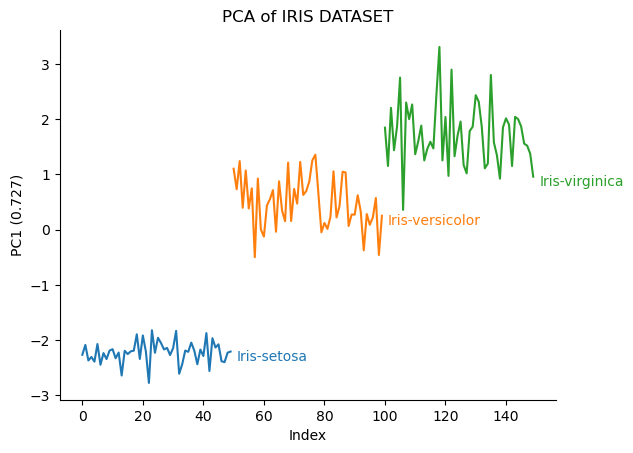

In [73]:
sns.lineplot(data=df_y,y="PC1",x=np.arange(150),hue="Species")
plt.title("PCA of IRIS DATASET")
plt.ylabel("PC1 (0.727)")
plt.xlabel("Index")
plt.legend().set_visible(False)

for line, name in zip(plt.gca().lines, df_y['Species'].unique()):
    y = line.get_ydata()[-1]   
    x = line.get_xdata()[-1]   
    color = line.get_color()   
    plt.text(x+2, y-0.1, name, va='center', ha='left', color=color,fontweight = "medium")  
    
    
sns.despine(top=True, right=True)

plt.savefig("PCA.png",dpi=300,bbox_inches='tight')

Looking at the graph, it is easy to see the difference between the flower types using the created PC1. Setosa is better separated from the other two flower types.